# Example of Parallelizing Pfof usage - TNG300 version

## Import Packages 

In [3]:
# All of Friends of Friends 
import FOF
import save_field
import region_merging
import numpy as np 
import astropy.cosmology 
import astropy.units as u
import pandas as pd
import math 
import glob
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM , Planck18
import time
from pydl.goddard.astro import gcirc
import astropy.units as u
import ray
from tqdm import trange
# declare ray instance for selecting number of cpu about usage
ray.init(num_cpus=10)
import sys
# recrusive depth option
sys.setrecursionlimit(10**6)
import Group_Summary


# upload file 

###   As in the example below, you should set the column names to match the pandas dataframe 

-  Dataframe column "ra","dec","redshift". ( ex) RA x, Ra x, ra o) It must be distinguished uppercase and lowercase.
-  At least redshift should be greater than $10^{-3}$

In [2]:

dir1 =  "/data/ehddbs98/fof_file/CNU_FOF_functions/" # write where is yourinput data file's directory
# df = pd.read_hdf(dir1+"13p75_.hdf")
df = pd.read_hdf(dir1+"tng300_000_ksmag19_b4.hdf")
df

,ra,dec,redshift,ID
0,48.151373,66.059742,0.05730,0
1,48.768449,64.785484,0.05702,1
2,47.814474,65.865509,0.05485,2
3,49.296716,65.539496,0.04981,3
4,48.245911,65.776701,0.05340,4
...,...,...,...,...
605079,58.579778,20.750812,0.03144,602700
605080,18.664673,11.305030,0.03005,602701
605081,33.931134,75.142269,0.05265,602702
605083,43.322485,3.061886,0.03059,602703


### cosmological parameters, light speed, linking length and nmin values must be set. 

In [3]:
H0 = 67.7          # Hubble parameter
omegamc = 0.3      # Matter parameter
omegalc = 0.7      # Dark Energy parameter 
omegakc = 0        # curverture Term 
c =2.998*10**5     # light speed        
dcondc = 500       # linking length (ra,dec)
vcondc = 350      # linking length (linear direction)
nmin = 2           # minimum value of particles per group

In [4]:
df_array = np.array(df)
np.savetxt(dir1+"tng300",df_array)

## From functions executing savefile
### This function divdes the regions and also divdes the common area

- My directory is dir2 
- The argument order of the function save file is as follows. 
 1. The number to be divded in the ra
 2. The number to be divded in the dec 
 3. Hubble constant 
 4. Dark matter Density paramter 
 5. To save file directory 
 
The output value is the maximum value of the angular distance, which is half the length of the common field in the dec direction 

### When the cell is executed, there will be files in which input particles are stored for each section in the directory you set 

In [8]:
dir2 =  "/data/ehddbs98/fof_file/field_file2/" # write your directory where the input data divided into ares will be stored 
save_field.save_file(df,0,10,67.7,0.3,500,dir2)

linkling_angular is 0.6548809190725494 [degree]
total divided field : 11


In [9]:
# check the minimum and maximum declination values for each divided area.
a = glob.glob(dir2+"field_*")
for i in a:
    print(min(np.loadtxt(i)[:,1]))
    print(max(np.loadtxt(i)[:,1]))

0.0
9.09914274447
6.79069578789
16.5447292922
15.2355207303
24.9901271924
23.6809186306
33.4349521349
32.125743573
41.8803500351
40.5711414732
50.3251749775
49.0165393734
58.7705728777
57.4613643159
67.2153978202
65.9067622161
75.6607957204
74.3515871585
84.105047705
82.796412101
89.9784380629


## Call the file name 

The area divded in the save file is designated as "field_*"

In [10]:
parallel_field_file = glob.glob(dir2+"field_*")

In [11]:
for i in parallel_field_file:
    print(len(np.loadtxt(i)))

73919
83548
92623
95166
101517
100650
62138
46722
25925
13115
4579


### To run the parallelized code, you need to do the following: The remote function is a function that receives the result value from ray at once. 

**caution) In the example, if "start" does appear at once, it is a problem with the number of cores or the ray version. 
Use a version close to the version introduced in the Readme.**

In [14]:
%%time
result = [FOF.mainloop.remote(i,H0,omegamc,omegalc,omegakc,c,dcondc,vcondc,nmin) for i in parallel_field_file]
parallel_results = ray.get(result)

(mainloop pid=699754) start
(mainloop pid=699755) start
(mainloop pid=699756) start
(mainloop pid=699758) start
(mainloop pid=699760) start
(mainloop pid=699759) start
(mainloop pid=699762) start
(mainloop pid=699763) start
(mainloop pid=699761) start
(mainloop pid=699754) 0.0 mins 55.0 second
(mainloop pid=699754) start
(mainloop pid=699754) 0.0 mins 14.0 second
(mainloop pid=699754) start
(mainloop pid=699754) 0.0 mins 2.0 second
(mainloop pid=699755) 3.0 mins 1.0 second
(mainloop pid=699756) 5.0 mins 12.0 second
(mainloop pid=699763) 7.0 mins 35.0 second
(mainloop pid=699762) 9.0 mins 19.0 second
(mainloop pid=699761) 11.0 mins 44.0 second
(mainloop pid=699759) 11.0 mins 57.0 second
(mainloop pid=699760) 13.0 mins 52.0 second
(mainloop pid=699758) 13.0 mins 56.0 second
CPU times: user 1.93 s, sys: 1.05 s, total: 2.97 s
Wall time: 13min 57s


### Merge divded field and common field found with fof

In [22]:
result= region_merging.region_merging(parallel_results[0],parallel_results[1])
for i in trange(1,len(parallel_results)-1):
    result= region_merging.region_merging(result,parallel_results[i+1])
print(result)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43.13it/s]

[[  0.00000000e+00   4.81513731e+01   6.60597419e+01   5.73000000e-02
    4.83713000e+05]
 [  1.00000000e+00   4.87684486e+01   6.47854838e+01   5.70200000e-02
    4.83713000e+05]
 [  2.00000000e+00   4.78144739e+01   6.58655093e+01   5.48500000e-02
    4.83713000e+05]
 ..., 
 [  6.02702000e+05   3.39311336e+01   7.51422689e+01   5.26500000e-02
    5.11123000e+05]
 [  6.02703000e+05   4.33224848e+01   3.06188646e+00   3.05900000e-02
    1.27619000e+05]
 [  6.02704000e+05   4.67934631e+01   2.76962069e+01   1.01070000e-01
    2.77910000e+04]]


In [23]:
# numpy array to pandas dataframe 
df_result = pd.DataFrame({'ID':result[:,0],'ra':result[:,1],'dec':result[:,2],'redshift':result[:,3],'Gname':result[:,4]})

In [24]:
# Finding the number of each groups. 
result_num= np.zeros(len(result))+-1
group = np.unique(result[:,4])
for i in trange(len(result_num)):
    if result_num[i] != -1:
        continue
    idx = np.where(result[:,4] == result[:,4][i])[0]
    result_num[idx] = int(idx.size)
df_result['Gnum'] = result_num
df_result

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272058/272058 [00:27<00:00, 9750.49it/s]


,ID,ra,dec,redshift,Gname,Gnum
0,0.0,48.151373,66.059742,0.05730,483713.0,1654.0
1,1.0,48.768449,64.785484,0.05702,483713.0,1654.0
2,2.0,47.814474,65.865509,0.05485,483713.0,1654.0
3,4.0,48.245911,65.776701,0.05340,483713.0,1654.0
4,6.0,48.872154,64.587240,0.05515,483713.0,1654.0
...,...,...,...,...,...,...
272053,602696.0,21.284236,4.387711,0.01289,65225.0,74.0
272054,602698.0,57.033938,59.490781,0.06108,4232.0,3.0
272055,602702.0,33.931134,75.142269,0.05265,511123.0,2.0
272056,602703.0,43.322485,3.061886,0.03059,127619.0,26.0


## If you have mass information in your data, you can add it to your output 

In [29]:
# def finding_mass(real_data,fake_data):
#     copy_fake = fake_data.copy()
#     fake_id = np.array(fake_data['ID'])
#     real_id = np.array(real_data['ID'])
#     all_idx = np.array([])

#     for i in trange(len(fake_id)):
#         all_idx = np.append(all_idx,np.where(fake_id[i]==real_id)[0]).astype(int)
#     copy_fake['mass'] = np.array(real_data['stmass'])[all_idx]
    
#     return copy_fake,all_idx
# # in my case, df : real simulation data / df_result : FOF output data 
# finding_mass= finding_mass(df,df_result)

# df_result = finding_mass[0]

### Result  - Using HEALPIX

<Figure size 1200x600 with 0 Axes>

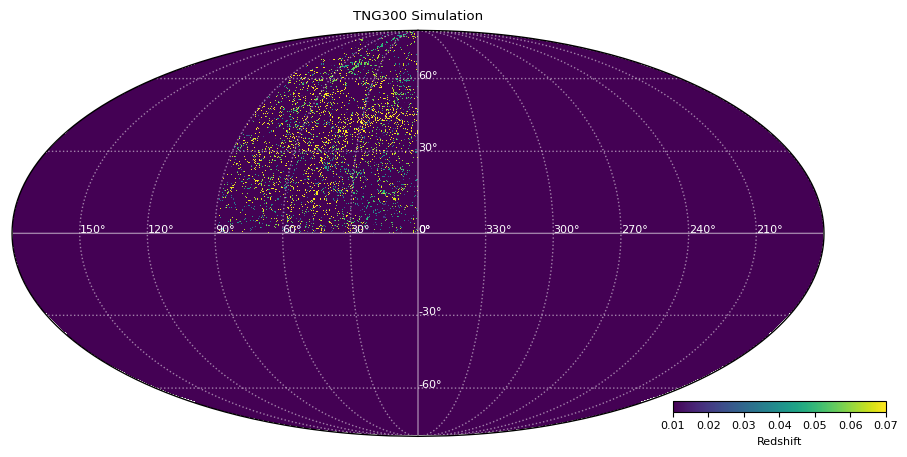

In [28]:
import healpy as hp
plt.rcParams['font.size'] = 8
# df = df_mrs.loc[df_mrs['z']>=0.001]
nside = 1024
npix = hp.nside2npix(nside)
ra = df_result['ra'].values
dec = df_result['dec'].values
redshift = df_result['redshift'].values

# RA, DEC를 theta, phi로 변환
theta = np.radians(90.0 - dec)
phi = np.radians(ra)
pixels = hp.ang2pix(nside, theta, phi)

fig = plt.figure(figsize=(12, 6))
# HEALPix 맵 초기화 및 데이터 할당
hpx_map = np.zeros(npix)
for pix, z in zip(pixels, redshift):
    hpx_map[pix] = max(hpx_map[pix], z)  # 각 픽셀에 최대 적색편이 값을 저장

# 맵 시각화
hp.mollview(hpx_map, title="TNG300 Simulation", unit='Redshift', cmap='viridis', min=0.01, max=0.07, cbar=False)
# RA 라인 및 라벨 추가
for ra in range(0, 360, 30):
    hp.projtext(np.pi/2, np.radians(ra), "{}°".format(ra), lonlat=False, coord='C', color="w")

# DEC 라인 및 라벨 추가
for dec in range(-60, 90, 30):
    hp.projtext(np.radians(90-dec), 0, "{}°".format(dec), lonlat=False, coord='C', color="w")

axes = plt.gca() 
image = axes.get_images()[0]  
cbar = plt.colorbar(image, ax=axes, orientation='horizontal', pad=0.05, fraction=0.04)
cbar.set_label('Redshift')


cbar.ax.set_position([0.8, 0.1, 0.25, 0.1]) 

    
hp.graticule(color="white",alpha=0.5)
plt.show()
